<h1>Daily and Sports Activities Classification </h1>


Each of the 19 activities is performed by eight subjects (4 female, 4 male, between the ages 20 and 30) for 5 minutes. 
Total signal duration is 5 minutes for each activity of each subject. 
The subjects are asked to perform the activities in their own style and were not restricted on how the activities should be performed. For this reason, there are inter-subject variations in the speeds and amplitudes of some activities. 
The activities are performed at the Bilkent University Sports Hall, in the Electrical and Electronics Engineering Building, 
and in a flat outdoor area on campus. Sensor units are calibrated to acquire data at 25 Hz sampling frequency. The 5-min signals are divided into 5-sec segments so that 480(=60x8) signal segments are obtained for each activity. 

The 19 activities are: 
sitting (A1), 
standing (A2), 
lying on back and on right side (A3 and A4), 
ascending and descending stairs (A5 and A6), 
standing in an elevator still (A7) 
and moving around in an elevator (A8), 
walking in a parking lot (A9), 
walking on a treadmill with a speed of 4 km/h (in flat and 15 deg inclined positions) (A1 
0 and A11), 
running on a treadmill with a speed of 8 km/h (A12), 
exercising on a stepper (A13), 
exercising on a cross trainer (A14), 
cycling on an exercise bike in horizontal and vertical positions (A15 and A16), 
rowing (A17), 
jumping (A18), 
and playing basketball (A19). 

File structure: 

19 activities (a) (in the order given above) 
8 subjects (p) 
60 segments (s) 
5 units on torso (T), right arm (RA), left arm (LA), right leg (RL), left leg (LL) 
9 sensors on each unit (x,y,z accelerometers, x,y,z gyroscopes, x,y,z magnetometers) 

<h1>PLEASE NOTE</h1>- I have generated two dataframes out of the data given on the  link , first one is raw signal data without any feature engineering and second one is created using features like mean, max, min,dtft,autocorelation etc. We have first used raw data to train a neural model then feature engineered data to train several models.

first dataframe comes from 'data.csv'

second comes from 'features.csv'

<h1>PLEASE NOTE</h1>- A lot of the ideas in this notebook are inspired/taken from this research paper-K. Altun, B. Barshan, and O. Tunçel,
<b>`Comparative study on classifying human activities with miniature inertial and magnetic sensors.</b>


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.metrics import accuracy_score
import gc
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Okay so lets first convert all the .txt files into .csv files so it becomes easy to handle data in it.

In [ ]:
#script for generating data , i'd suggest to directly call the csv file i have provided.
for i in range(1,20):                               #looping over activity folder
    for j in range(1,9):                            #looping over individual folder
        for t in range(1,61):                       #looping over segments , each segments represents 5 sc signal from different sensors
            if(i<10):
                activity='a0'+str(i)
            else:
                activity='a'+str(i)
            person='p'+str(j)
            if t<10:
                seg='s0'+str(t)
            else:
                seg='s'+str(t)
            path='data/'+activity+'/'+person+'/'+seg+'.txt'
            file = open(path,'r+')
            String=file.read()
            file.close()
            #print(String)
            path='data/'+activity+'/'+person+'/'+seg+'.csv'
            file = open(path, "w")
            file.write(String)
            file.close()


OKay now that we have the files in csv format , lets quickly visualize of portion of signal from a sensor for an individual.

In [2]:
#this unction helps us a genrate the full 5 mintue signal from a particular sensor for an individual for a particular activity
def generate_sig(sensor,person,actvity):
    signal=np.array([])
    for i in range(1,61):
        a=str(i)
        if i<10: a='s0'+a
        else: a='s'+a
        if actvity<10:b='0'+str(actvity)
        else:b=str(actvity)
        signal_data=df=pd.read_csv('data/a'+b+'/p'+str(person)+'/'+a+'.csv')
        cols=signal_data.columns.values
        signal_segment=np.array(signal_data[cols[sensor]].values)
        signal=np.concatenate((signal, signal_segment), axis=0)
        del cols,signal_segment,signal_data
    return signal


 <h1>Activity 1  </h1>

0.11038998924555089

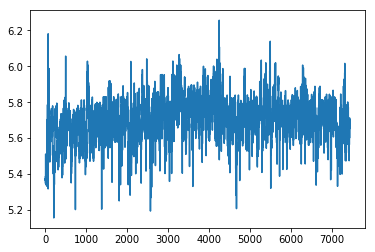

In [3]:
signal=generate_sig(2,1,1)
plt.plot(signal)
np.std(signal)

0.12300271750416869

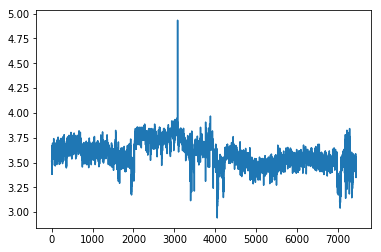

In [4]:
signal=generate_sig(2,3,1)
plt.plot(signal)
np.std(signal)

0.055388918258640715

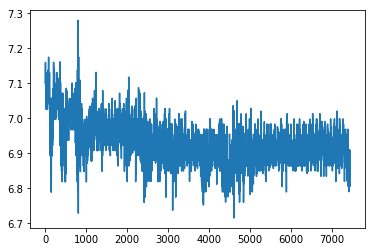

In [5]:
signal=generate_sig(2,5,1)
plt.plot(signal)
np.std(signal)

At first glance , the graphs may look completely different but it seems their standard deviation is usualy rtty close , it can make a ood feature.

 <h1>Activity 5  </h1>

0.23642957109935844

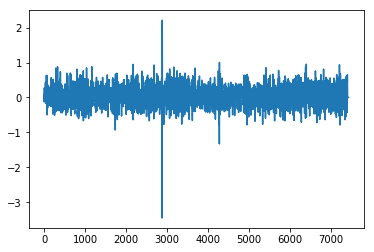

In [219]:
signal=generate_sig(4,1,5)
plt.plot(signal)
np.std(signal)

0.25872591973525311

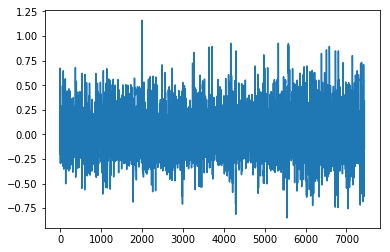

In [220]:
signal=generate_sig(4,2,5)
plt.plot(signal)
np.std(signal)

0.22380848574877193

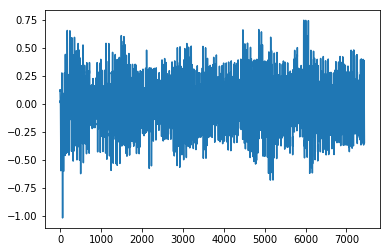

In [221]:
signal=generate_sig(4,3,5)
plt.plot(signal)
np.std(signal)

Now signal from sensor 4 seems really similar for the participants , alll of them seem to have standard deviation aof around 0.22

So we observe that for a particular activity and sensor , we usually get same kind of sigal from different participant for example , signal produced from walking for different participant will have similar statistics , this is an important face , we can just use statistics of a signal instead of each feature value and significantly bring down the number of features.

Now to adress the question " Each activity signal will have variation across subjects. How will you handle this?"
We can use a very simple transformation s=log(s+1), this transformation is usualy done to reduce the effects of outliers , what it does is , it brings data points closer to the mean of all data points , as two signals from two differnt will have similar signals statistics , applything this transformation will definatly help.


Lets see by plotng both the transformation.

 <h1> After transforming </h1>

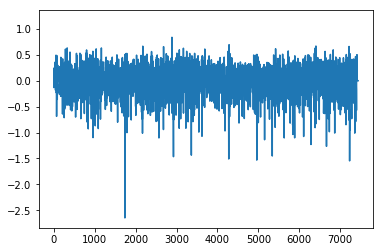

In [6]:
signal=generate_sig(4,1,5)
signal=np.log(signal+1)
plt.plot(signal)


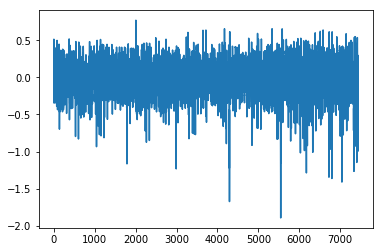

In [7]:
signal=generate_sig(4,2,5)
signal=np.log(signal+1)
plt.plot(signal)


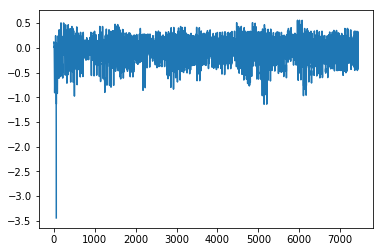

In [8]:
signal=generate_sig(4,3,5)
signal=np.log(signal+1)
plt.plot(signal)


Great it works! , if we look at the y-axis scale and except for few outliers , signals are following pretty much the same pattern , they are mostly limited bw 0.5 and -0.5



Okay time to create the raw dataset for modelling , our features will be all values of a 5 sec signal segment. Since we are sampling at 25khz , will will create 5*25=125 features and we have 5 units of 9 sensors , so a total of 45 sensors generating data , so total features= 45*125= 5625 features.

Now we have 19 activites , 8 participants and 60 segments , so total feature vectors will be 19*8*60=9120.

so the final shape will be (9120,5625).

In [ ]:
#script for generating data , i'd suggest to directly call the csv file i have provided.
initialize=np.array(range(45*125))  #used to initialize the size o our numpy array
raw_data=np.array([initialize])     #our numpy array
for i in range(1,20):
    for j in range(1,9):
        for t in range(1,61):
            if(i<10):
                activity='a0'+str(i)
            else:
                activity='a'+str(i)
            person='p'+str(j)
            if t<10:
                seg='s0'+str(t)
            else:
                seg='s'+str(t)
            path='data/'+activity+'/'+person+'/'+seg+'.csv'
            df=pd.read_csv(path)      
            temp=df.columns.values      #since our csv file had no colums , the first row data became coulmn by default so stre it and ut it at the end later
            df.columns=range(45)          #assigning new column names
            df.loc[124]=temp
            main=np.array([])
            for n in range(45):
                temp=np.array(df[n].values)
                main=np.concatenate((main, temp), axis=0)
            main=np.array([main])
            #print(raw_data.shape)
            raw_data=np.concatenate((raw_data,main),axis=0 )
            del main,df,temp            

In [9]:

#df = pd.DataFrame(raw_data)           #converting numpy to pandas dataframe for easier data handling
#del raw_data                          #freeing up the memory
#df.to_csv('/home/harsh/Videos/yy.csv', sep='\t')   #saving the dataframe
df=pd.read_csv('data.csv', sep='\t')
#An extra row was aded in the dataframe due to conversion so drop it
df=df.drop(df.index[0]) 
cols=df.columns.values

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1125,1250,1375,1500,1750,2250,2375,3125,3375,3750,3875,4000,4125,4250,4375,4500,4625,4875,5000,5125,5250,5375,5500,5625) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
#print(df.shape)
df[cols].dtypes.value_counts()

float64    5601
object       24
int64         1
dtype: int64

Okay we see there are some columns that arent float or int , these have to be converted , if we look at these columns , we see that some values are incorrect , there are values like 1.2342.1  , such values have to be deleted and replaced with -9999 or 0.

In [11]:
#cleaning df 
for i in cols:
    #print(i)
    if df[i].dtypes=='float64':
        continue
    df[i]=pd.to_numeric(df[i], errors='coerce')
    
df.fillna(0,inplace=True) 

In [12]:
#lets normalize the data in df
for i in cols:
    df[i]=(df[i]-df[i].min())/(df[i].max()-df[i].min())

Now lets build the y labels for the dataframe , we will be using one hot encoding for better performance on our neural network.

In [13]:
 
y_one_hot=np.zeros([df.shape[0], 19])
index=0
row_i=0
while index!=19:
    for i in range(480):
        new=row_i+i
        y_one_hot[new][index]=1
    row_i=row_i+480
    index=index+1
        

Okay now lets split our dataset into training set and validation(80%-20%).

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df, y_one_hot, test_size=0.2, random_state=0)

Okay now lets train our first model neural network , we are going to be using 3 layer deep neural network with softmax_cross entropy and adam aptimizer.

In [15]:
import tensorflow as tf
import numpy as np
n_nodes_hl1 = 1000  #number of nodes in layer one
n_nodes_hl2 = 1000
n_nodes_hl3 = 1000
accuracy=0

n_classes = 19
batch_size = 350

x = tf.placeholder('float', [None, (X_train.shape[1])])
y = tf.placeholder('float')
keep_prob = tf.placeholder('float')

def neural_network_model(data):
    hidden_1_layer = {'weights':tf.Variable(tf.random_normal([(X_train.shape[1]), n_nodes_hl1])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}

    hidden_3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl3]))}

    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                    'biases':tf.Variable(tf.random_normal([n_classes])),}


    l1 = tf.add(tf.matmul(data,hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)
    drop_out = tf.nn.dropout(l1, keep_prob)  # DROP-OUT here

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)
    drop_out = tf.nn.dropout(l2, keep_prob)  # DROP-OUT here

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)
    drop_out = tf.nn.dropout(l3, keep_prob)  # DROP-OUT here

    output = tf.matmul(l3,output_layer['weights']) + output_layer['biases']

    return output


def train_neural_network(x,probablity,hm_epochs):
    prediction = neural_network_model(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    #optimizer = tf.train.MomentumOptimizer(momentum=0.1,learning_rate=0.1).minimize(cost)
    #optimizer = tf.train.ProximalGradientDescentOptimizer().minimize(cost)
    #optimizer = tf.train.RMSPropOptimizer(learning_rate=0.5).minimize(cost)
    
    
    
    
    with tf.Session() as sess:
        # OLD:
        #sess.run(tf.initialize_all_variables())
        # NEW:
        sess.run(tf.global_variables_initializer())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            i=0
            end=batch_size
            while end<(X_train.shape[0]):
                epoch_x=np.array(X_train[i:end])
                epoch_y=np.array(y_train[i:end])
                i=i+batch_size
                end=end+batch_size
                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y,keep_prob:probablity})
                epoch_loss += c
            if epoch%2==0:
                print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy_val:',accuracy.eval({x:X_val, y:y_val,keep_prob:1}))
        print('Accuracy_train:',accuracy.eval({x:X_train, y:y_train,keep_prob:1}))

train_neural_network(x,1,100)
del df
del X_val,X_train

Epoch 0 completed out of 100 loss: 5165841.5
Epoch 2 completed out of 100 loss: 326453.448242
Epoch 4 completed out of 100 loss: 170677.685547
Epoch 6 completed out of 100 loss: 104091.01123
Epoch 8 completed out of 100 loss: 75787.5281982
Epoch 10 completed out of 100 loss: 52522.2423096
Epoch 12 completed out of 100 loss: 46187.074707
Epoch 14 completed out of 100 loss: 43937.9535522
Epoch 16 completed out of 100 loss: 34456.9215088
Epoch 18 completed out of 100 loss: 27240.6763916
Epoch 20 completed out of 100 loss: 24416.2245483
Epoch 22 completed out of 100 loss: 20200.59198
Epoch 24 completed out of 100 loss: 20330.7872009
Epoch 26 completed out of 100 loss: 18720.6828918
Epoch 28 completed out of 100 loss: 19095.1682739
Epoch 30 completed out of 100 loss: 21207.3504639
Epoch 32 completed out of 100 loss: 14388.314743
Epoch 34 completed out of 100 loss: 22587.6907654
Epoch 36 completed out of 100 loss: 12622.9795227
Epoch 38 completed out of 100 loss: 10054.0744629
Epoch 40 compl

Okay great , our model performed pretty good on just raw data.


Now lets do some feature engineering.
As we saw in our visualization , our signals for a particular activity are pretty similar , we can actually just use some statistic of the signal rather than all value , so lets calculate some important statistc for every segment.
We are going to be using the following statistic-
maximum value,
minimum value,
mean,
skewness,
kurtosis,
autocorrelation (we use 11 values),
DFT (we use biggest 5 peaks  and their corresponding frequencies).

so for a single segment we get(1+1+1+1+1+11+5+5), now we have 45 different units so we multiply it by 45 giving us a total of 26*45=1170 features.
So now we will have a dataset of  shape (9120,1170)



In [16]:
def dtft(s):
    dt=t=np.fft.fft(s)
    dt.sort()
    #print(dt)
    real=dt.real
    imag=dt.imag
    return np.concatenate((real[-5:],imag[-5:]),axis=0)
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result =result[int(result.size/2):]
    new=[result[0]]
    for i in range(1,11):
        new.append(result[i*5])
    return np.array(new)




In [ ]:

#script to generate hand engineered dataset.
initialize=np.array(range(1170))
signal_data=np.array([initialize])
for i in range(1,20):
    #print(i)
    for j in range(1,9):
        for t in range(1,61):
            if(i<10):
                activity='a0'+str(i)
            else:
                activity='a'+str(i)
            person='p'+str(j)
            if t<10:
                seg='s0'+str(t)
            else:
                seg='s'+str(t)
            path='data/'+activity+'/'+person+'/'+seg+'.csv'
            df=pd.read_csv(path)
            temp=df.columns.values
            df.columns=range(45)
            df.loc[124]=temp
            main=np.array([])
            for n in range(45):
                df[n]=pd.to_numeric(df[n], errors='coerce')
                df[n].fillna(0,inplace=True) 
                s=np.array(df[n].values)
                a=s.max()
                b=s.min()
                c=s.mean()
                d=scipy.stats.kurtosis(s)
                e=scipy.stats.skew(s)
                main=np.concatenate((main, np.array([a,b,c,d,e])), axis=0)
                peaks_11=dtft(s)
                #print(peaks_11)
                main=np.concatenate((main, peaks_11), axis=0)
                dft_6=autocorr(s)
                main=np.concatenate((main, dft_6), axis=0)
            main=np.array([main])
            #print(raw_data.shape)
            signal_data=np.concatenate((signal_data,main),axis=0 )
            del main,df,temp            

Okay now we have reduced our datset by 4 times and have produced data that captures the structure of signals.
Now lets clean it like we cleaned raw_data.

In [17]:
#df = pd.DataFrame(signal_data)
#df4.to_csv('/home/harsh/Videos/features.csv', sep='\t')
#del df

df=pd.read_csv('features.csv', sep='\t')  

df=df.drop(df.index[0])

In [18]:
cols=df.columns.values
#cleaning df 
for i in cols:
    
    if df[i].dtypes=='float64':
        continue
    df[i]=pd.to_numeric(df[i], errors='coerce')

In [19]:
#filling in n/a  with 0
df.fillna(0,inplace=True) 
#lets normalize the data in df
for i in cols:
    #print(df4[i].var())
    df[i]=(df[i]-df[i].min())/(df[i].max()-df[i].min())

In [20]:
X_train, X_val, y_train, y_val = train_test_split(df, y_one_hot, test_size=0.2, random_state=0)

In [21]:
n_nodes_hl1 = 800
n_nodes_hl2 = 500
n_nodes_hl3 = 500
accuracy=0

n_classes = 19
batch_size = 200

x = tf.placeholder('float', [None, (X_train.shape[1])])
y = tf.placeholder('float')
train_neural_network(x,1,50)
#del X_val,X_train

Epoch 0 completed out of 50 loss: 771982.253418
Epoch 2 completed out of 50 loss: 15509.5227966
Epoch 4 completed out of 50 loss: 7067.18413925
Epoch 6 completed out of 50 loss: 3857.14968681
Epoch 8 completed out of 50 loss: 2813.29526424
Epoch 10 completed out of 50 loss: 2595.83993125
Epoch 12 completed out of 50 loss: 2122.53493595
Epoch 14 completed out of 50 loss: 2097.67176247
Epoch 16 completed out of 50 loss: 1931.43959379
Epoch 18 completed out of 50 loss: 753.521459103
Epoch 20 completed out of 50 loss: 749.031815261
Epoch 22 completed out of 50 loss: 863.403403759
Epoch 24 completed out of 50 loss: 1238.22023106
Epoch 26 completed out of 50 loss: 1049.32472149
Epoch 28 completed out of 50 loss: 935.120085716
Epoch 30 completed out of 50 loss: 1191.7918213
Epoch 32 completed out of 50 loss: 1209.63023564
Epoch 34 completed out of 50 loss: 1334.45606136
Epoch 36 completed out of 50 loss: 1944.17070675
Epoch 38 completed out of 50 loss: 3088.0628829
Epoch 40 completed out of 5

With a less complex model , our hand engineered dataset performs better than raw data, but there still scope for improvement as the baseline is 99.2% as given in the research paper,
so now lets use PCA to skim out unnecesary features.

It turns our dropout didnt improve the score at all for this neural network so keep_prob=1 (no dropouts).

<h1>PCA</h1>

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

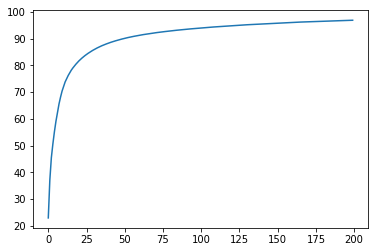

In [23]:
#plotting culiminative variance capured by new features
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)

From the plot we can see 150 is a good choice as it captures most of the variance in data.



<h1>Note</h1>- we have to make sure , we generate new features only from X_train  and then apply the same transformation on X_val , if we generate the features out of X_train and X_val together, the validation will leak into our training which is against the idea of builing generalized model and validation.

In [24]:
pca = PCA(n_components=150)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [25]:
X_train=pca.transform(X_train)
X_val=pca.transform(X_val)
df=pca.transform(df)

Alright time to visualize our new features to see how much structure they have captured of different classes.

In [26]:
#labels in 1-d array
y_1d=np.argmax(y_one_hot, axis=1)
#columns of new df
df=pd.DataFrame(df)
cols=df.columns.values


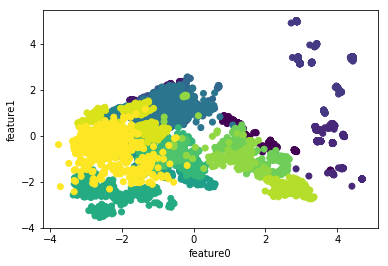

In [27]:
colors=[i%23 for i in y_1d]
plt.scatter(df[cols[0]], df[cols[1]], c=colors)
plt.xlabel("feature0")
plt.ylabel("feature1")

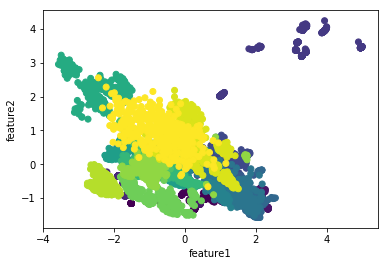

In [28]:
plt.scatter(df[cols[1]], df[cols[2]], c=colors)
plt.xlabel("feature1")
plt.ylabel("feature2")

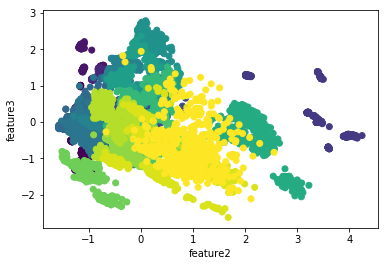

In [29]:
plt.scatter(df[cols[2]], df[cols[3]], c=colors)
plt.xlabel("feature2")
plt.ylabel("feature3")

We can see datapoints of a particular class are mostly grouped together and we can easily see classes are distinguishabled in our new features.


Okay great!our new features are distinguising classes pretty clearly , we have managed to retain information in our features and they are capturing the structure just fine.


Alright lets make a train set and validation set .

In [60]:
n_nodes_hl1 = 1000
n_nodes_hl2 = 500
n_nodes_hl3 = 100
accuracy=0

n_classes = 19
batch_size = 200

x = tf.placeholder('float', [None, (X_train.shape[1])])
y = tf.placeholder('float')
train_neural_network(x,1,80)

Epoch 0 completed out of 80 loss: 233256.006104
Epoch 2 completed out of 80 loss: 3989.10858536
Epoch 4 completed out of 80 loss: 1076.72021556
Epoch 6 completed out of 80 loss: 486.554423809
Epoch 8 completed out of 80 loss: 239.005416919
Epoch 10 completed out of 80 loss: 127.065562201
Epoch 12 completed out of 80 loss: 66.3443169966
Epoch 14 completed out of 80 loss: 57.5907511155
Epoch 16 completed out of 80 loss: 41.3434601426
Epoch 18 completed out of 80 loss: 31.9712599067
Epoch 20 completed out of 80 loss: 15.8523635071
Epoch 22 completed out of 80 loss: 11.8089497044
Epoch 24 completed out of 80 loss: 30.5320037384
Epoch 26 completed out of 80 loss: 11.740680473
Epoch 28 completed out of 80 loss: 31.3815636251
Epoch 30 completed out of 80 loss: 19.0059097894
Epoch 32 completed out of 80 loss: 49.4145848101
Epoch 34 completed out of 80 loss: 14.7372584641
Epoch 36 completed out of 80 loss: 49.9790085554
Epoch 38 completed out of 80 loss: 29.6727397032
Epoch 40 completed out of 

Great , we have achieved accuracy of 0.98 , i am sure if we let the mode train a bit more , we can achieve 0.99 accuracy but lets see how other descent algorithms work.

Again dopout didnt help.

Also i use 4 different methods for optimization adam,rmsprop,momentum and gradien descent , adam optimizer convereged fastest and i would recommend it over the others.

Okay time to see how other models fare . We will be using logistic regression,KNN, naive bayes(2 versions) and gradient boosting.We will be using hand engineered features.

In [30]:
from sklearn.linear_model import LogisticRegression
y_val=pd.DataFrame(y_val)         #converting np.arrays into dataframe, as we will be using one vs all classification
y_train=pd.DataFrame(y_train)     #so to make data handling easier we make them dataframe.
target_col=y_val.columns.values

In [31]:
prd = np.zeros((X_val.shape[0],19))
models={}
for i,col in enumerate(target_col):
    models[i] = LogisticRegression(C=4,random_state = i)
    print('Building {} model for column:{''}'.format(i,col)) 
    models[i].fit(X_train,y_train[col])
    #print(models[i].score())
    prd[:,i] = models[i].predict_proba(X_val)[:,1]

Building 0 model for column:0
Building 1 model for column:1
Building 2 model for column:2
Building 3 model for column:3
Building 4 model for column:4
Building 5 model for column:5
Building 6 model for column:6
Building 7 model for column:7
Building 8 model for column:8
Building 9 model for column:9
Building 10 model for column:10
Building 11 model for column:11
Building 12 model for column:12
Building 13 model for column:13
Building 14 model for column:14
Building 15 model for column:15
Building 16 model for column:16
Building 17 model for column:17
Building 18 model for column:18


Okay now lets calculate accuracy of our model.

In [32]:
predicton_logit=np.argmax(prd, axis=1)
ground_truth=np.argmax(np.array(y_val), axis=1)
accuracy = accuracy_score(ground_truth, predicton_logit)

print(accuracy)
        

0.990679824561


Great! logistic regression is performing great, this also tells us our neural network is overfitting so mabe we should use regularization like dropouts. 






Okay now we will see how knn performs but before that we need to change our target labels , as knn doesnt work with one hot encoded target , we will convet it into 1-d array , with values between 0-18 , representing the 19 classes.

In [33]:
y_train_knn=np.argmax(np.array(y_train), axis=1)
y_val_knn=np.argmax(np.array(y_val), axis=1)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train_knn)
pred_knn=neigh.predict(X_val)
print(pred_knn)

[14  9 14 ...,  6  6  3]


In [35]:
accuracy = accuracy_score(y_val_knn, pred_knn)
accuracy

0.98629385964912286

 After tuning a  little bit ,n_neighbors=5 seemed to be the optimum value.
 
Alright, lets see how naive bayes perform.

In [36]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train_knn)
pred_nb=gnb.predict(X_val)
print(pred_knn)

[14  9 14 ...,  6  6  3]


In [37]:
accuracy = accuracy_score(ground_truth, pred_nb)
print(accuracy)

0.947916666667


In [38]:
from sklearn.naive_bayes import BernoulliNB
mnb = BernoulliNB()
mnb.fit(X_train, y_train_knn)
pred_nb=mnb.predict(X_val)
print(pred_knn)

[14  9 14 ...,  6  6  3]


In [39]:

accuracy = accuracy_score(ground_truth, pred_nb)
print(accuracy)

0.964364035088


Okay , now we will see how gradient boosting tree works.

Fist lets convert y labels into arrays xgboost can work with , same as we did for knn model.

In [40]:
y_train_xg=np.argmax(np.array(y_train), axis=1)
y_val_xg=np.argmax(np.array(y_val), axis=1)

In [308]:

import xgboost as xgb

xg_train = xgb.DMatrix(X_train, label=y_train_xg)
xg_test = xgb.DMatrix(X_val, label=y_val_xg)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.02
param['max_depth'] = 6
param['silent'] = 0
param['nthread'] = 4
param['num_class'] = 19

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 200
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test)
#error_rate = np.sum(pred != test_Y) / test_Y.shape[0]

[0]	train-merror:0.026316	test-merror:0.069079
[1]	train-merror:0.021382	test-merror:0.055373
[2]	train-merror:0.019326	test-merror:0.052632
[3]	train-merror:0.017544	test-merror:0.04989
[4]	train-merror:0.01494	test-merror:0.045504
[5]	train-merror:0.013021	test-merror:0.045504
[6]	train-merror:0.012198	test-merror:0.041118
[7]	train-merror:0.012198	test-merror:0.038377
[8]	train-merror:0.011924	test-merror:0.037281
[9]	train-merror:0.010691	test-merror:0.035636
[10]	train-merror:0.010828	test-merror:0.036184
[11]	train-merror:0.010828	test-merror:0.035636
[12]	train-merror:0.010417	test-merror:0.035088
[13]	train-merror:0.010005	test-merror:0.033991
[14]	train-merror:0.010005	test-merror:0.032346
[15]	train-merror:0.009868	test-merror:0.030702
[16]	train-merror:0.009594	test-merror:0.030154
[17]	train-merror:0.009457	test-merror:0.029057
[18]	train-merror:0.00932	test-merror:0.027412
[19]	train-merror:0.009183	test-merror:0.026864
[20]	train-merror:0.009046	test-merror:0.026864
[21]	

[170]	train-merror:0.000411	test-merror:0.016447
[171]	train-merror:0.000411	test-merror:0.016447
[172]	train-merror:0.000411	test-merror:0.016447
[173]	train-merror:0.000411	test-merror:0.016447
[174]	train-merror:0.000411	test-merror:0.016447
[175]	train-merror:0.000411	test-merror:0.016447
[176]	train-merror:0.000411	test-merror:0.016447
[177]	train-merror:0.000411	test-merror:0.016447
[178]	train-merror:0.000411	test-merror:0.015899
[179]	train-merror:0.000411	test-merror:0.015899
[180]	train-merror:0.000411	test-merror:0.015899
[181]	train-merror:0.000411	test-merror:0.015899
[182]	train-merror:0.000274	test-merror:0.015899
[183]	train-merror:0.000274	test-merror:0.015899
[184]	train-merror:0.000274	test-merror:0.015899
[185]	train-merror:0.000274	test-merror:0.015899
[186]	train-merror:0.000274	test-merror:0.015899
[187]	train-merror:0.000274	test-merror:0.015899
[188]	train-merror:0.000274	test-merror:0.015899
[189]	train-merror:0.000274	test-merror:0.015351
[190]	train-merror:0

In [309]:
accuracy = accuracy_score(y_val_xg, pred)
accuracy

0.98519736842105265

After tuning a little bit , I was able to bring the cost down to 0.98 , interestingly , if we increase num_round to 500 , we can get 0.99 accuracy but we also get 0 errror on training set , maybe the model wont generalize well , so lets stick to thos model only.

<h1>Task 2</h1>

<br>Activity wise data to predict which subject this belongs to</br>

In this problem we simply use the same data we found through PCA on our hand engineered data, we just need to change y labels of acivity to labels represing participants , so we will have 8 groups to classify data to.

In [41]:
y_new_one_hot=np.zeros([df.shape[0], 8])
row_index=0
for i in range(19):
    for j in range(8):
        for seg in range(60):
            y_new_one_hot[row_index][j]=1
            row_index=row_index+1
            



Okay now we have correct y labels in one hot encoded form i.e if y[i][2]=1, then ith row in our data belongs to 2nd participant.

Now lets split them into traing and validation set.

In [42]:
X_train, X_val, y_train, y_val = train_test_split(df, y_new_one_hot, test_size=0.2, random_state=8)
X_train.shape

(7296, 150)

Now lets train a neural network.

In [43]:
n_nodes_hl1 = 1000
n_nodes_hl2 = 1000
n_nodes_hl3 = 1000
accuracy=0

n_classes = 8
batch_size = 250

x = tf.placeholder('float', [None, (X_train.shape[1])])
y = tf.placeholder('float')
train_neural_network(x,1,50)

Epoch 0 completed out of 50 loss: 523747.547852
Epoch 2 completed out of 50 loss: 31980.8136292
Epoch 4 completed out of 50 loss: 10423.7449341
Epoch 6 completed out of 50 loss: 4600.26736355
Epoch 8 completed out of 50 loss: 2034.79067612
Epoch 10 completed out of 50 loss: 1258.63822508
Epoch 12 completed out of 50 loss: 1361.2800879
Epoch 14 completed out of 50 loss: 1073.96883643
Epoch 16 completed out of 50 loss: 3571.8354426
Epoch 18 completed out of 50 loss: 708.037859201
Epoch 20 completed out of 50 loss: 355.594692796
Epoch 22 completed out of 50 loss: 416.226055622
Epoch 24 completed out of 50 loss: 1427.80731928
Epoch 26 completed out of 50 loss: 738.056595922
Epoch 28 completed out of 50 loss: 966.297485828
Epoch 30 completed out of 50 loss: 2310.4703908
Epoch 32 completed out of 50 loss: 491.002877712
Epoch 34 completed out of 50 loss: 2769.61142468
Epoch 36 completed out of 50 loss: 1156.61580884
Epoch 38 completed out of 50 loss: 440.214432716
Epoch 40 completed out of 50

Unfortunately it seems its overfitting  ,elst see how logistic regression performs.

In [44]:
y_val=pd.DataFrame(y_val)         #converting np.arrays into dataframe, as we will be using one vs all classification

y_train=pd.DataFrame(y_train)     #so to make data handling easier we make them dataframe.
target_col=y_val.columns.values

In [45]:
from sklearn.linear_model import LogisticRegression
prd = np.zeros((X_val.shape[0],8))
models2={}
for i,col in enumerate(target_col):
    models2[i] = LogisticRegression(C=4,random_state = i)
    print('Building {} model for column:{''}'.format(i,col)) 
    models2[i].fit(X_train,y_train[col])
    #print(models[i].score())
    prd[:,i] = models2[i].predict_proba(X_val)[:,1]

Building 0 model for column:0
Building 1 model for column:1
Building 2 model for column:2
Building 3 model for column:3
Building 4 model for column:4
Building 5 model for column:5
Building 6 model for column:6
Building 7 model for column:7


In [46]:
predicton_logit=np.argmax(prd, axis=1)
ground_truth=np.argmax(np.array(y_val), axis=1)
accuracy = accuracy_score(ground_truth, predicton_logit)

print(accuracy)
        

0.938596491228


Quite interesting , logistic regression seems to be performing similar to neural net.

<h1> CONCLUSION </h1>



1)Neural network performed pretty good on raw data itself.

2)Hand engineered data reduced the data size , gave it a better structure and consquently improved our neural network model.

3)PCA further reduced about 1000 features to just about 150 features , this even led to better performance.

4)Logistic regression performed the best with PCA features , giving us an accuracy of 99.2%.

5)Other models worked pretty decent too , giving us average accuracy of 96%

6)After PCA , our neural network became prone to overfitting , maybe we can reduce the number of layers to just 2 to reduce the complexity.

7)For the second task , neural network and logistic regression performed pretty good without any new features.